In [1]:
import numpy as np
import torch
import torchvision
from torch.nn.parallel import DataParallel
from torchvision.transforms import ToTensor, Compose
import matplotlib.pyplot as plt

from segment_anything.utils.transforms import ResizeLongestSide

from datasets import Embedding_Dataset
from utils import SAMPreprocess, PILToNumpy, NumpyToTensor, SamplePoint, embedding_collate
from models import SAM_Baseline
from test import create_dataloaders, test_model, plot_iou_scores

In [2]:
batch_size = 8
folder_paths = [
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/Liebherr/dataset',
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/FSSAM Datasets/EgoHOS/dataset',
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/FSSAM Datasets/GTEA/dataset',
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/FSSAM Datasets/LVIS/dataset',
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/FSSAM Datasets/NDIS Park/dataset',
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/FSSAM Datasets/TrashCan/dataset',
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/FSSAM Datasets/ZeroWaste-f/dataset',
]
only_liebherr = False

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SAM_Baseline()
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = DataParallel(model)
model.to(device)
print("SAM loaded")

SAM loaded


In [4]:
sam_transform = ResizeLongestSide(model.img_size)
target_transform = Compose([
    sam_transform.apply_image_torch, # rescale
    SAMPreprocess(model.img_size, normalize=False), # padding
    SamplePoint(),
])
transform = Compose([
    PILToNumpy(),
    sam_transform.apply_image, # rescale
    NumpyToTensor(),
    SAMPreprocess(model.img_size) # padding
])

if only_liebherr:
    folder_paths = [folder_paths[0]]
    
dataloaders = create_dataloaders(folder_paths, transform=transform, target_transform=target_transform,
                                 collate_fn=embedding_collate, batch_size=batch_size)

In [5]:
iou_scores, oracle_iou_scores, dataset_names = test_model(model, dataloaders, device)

Testing Liebherr


100%|██████████| 106/106 [07:01<00:00,  3.97s/it, IoU=0.508, oracle IoU=0.654]


Average IoU tensor(0.5077)
Average Oracle IoU tensor(0.6541)
Testing EgoHOS


100%|██████████| 125/125 [05:40<00:00,  2.72s/it, IoU=0.562, oracle IoU=0.716]


Average IoU tensor(0.5616)
Average Oracle IoU tensor(0.7160)
Testing GTEA


100%|██████████| 82/82 [02:57<00:00,  2.17s/it, IoU=0.769, oracle IoU=0.882]


Average IoU tensor(0.7686)
Average Oracle IoU tensor(0.8821)
Testing LVIS


100%|██████████| 125/125 [05:24<00:00,  2.59s/it, IoU=0.495, oracle IoU=0.714]


Average IoU tensor(0.4951)
Average Oracle IoU tensor(0.7136)
Testing NDIS Park


100%|██████████| 14/14 [01:38<00:00,  7.06s/it, IoU=0.523, oracle IoU=0.707]


Average IoU tensor(0.5227)
Average Oracle IoU tensor(0.7071)
Testing TrashCan


100%|██████████| 125/125 [04:44<00:00,  2.28s/it, IoU=0.288, oracle IoU=0.501]


Average IoU tensor(0.2876)
Average Oracle IoU tensor(0.5006)
Testing ZeroWaste-f


100%|██████████| 125/125 [06:26<00:00,  3.09s/it, IoU=0.27, oracle IoU=0.394] 

Average IoU tensor(0.2699)
Average Oracle IoU tensor(0.3939)


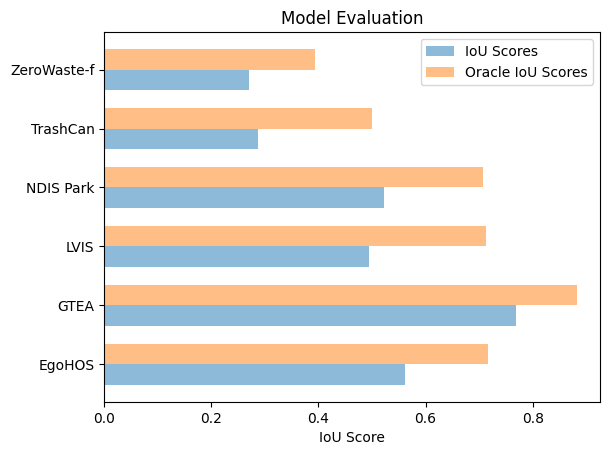

0.48424324 0.6522099


In [6]:
plot_iou_scores(iou_scores[1:], oracle_iou_scores[1:], dataset_names[1:])
print(np.mean(iou_scores[1:]), np.mean(oracle_iou_scores[1:]))